In [49]:
%matplotlib notebook
import numpy as np
from modsim import *
import math
import numpy as np

# 125 meters in between each building in distance, 11 meters in height

In [53]:
#################################################### FRISBEE SYSTEM ############################################################
def make_frisbee_system(v, alpha, duration):
    """
    Makes a frisbee object, but really it's a System object with a state object.
    x = Inital x coordinate of the disk.
    y = Inital y coordinate of the disk.
    vx = Inital x velocity of the disk.
    vy = Initial y velocity of the disk.
    alpha = Angle of the disk being thrown
    
    Returns a system object with all of the good stuff needed for the slope function and all of that.
    """
    x= 0
    y = 0
    vx = abs(v*math.cos(alpha))
    vy = abs(v*math.sin(alpha))

    init = State(x=x, y=y, vx=vx, vy=vy)
    g = 9.8 #* UNITS.meter / UNITS.second**2
    m = .175 #* UNITS.kilogram # Mass of frisbee
    rho = 1.23  #* UNITS.kilogram/UNITS.meter**3 # Density of air
    area = 0.0568 #* UNITS.meter**2 # Surface area of frisbee
    CL0 = 0. # Lift coefficient alpha=0.
    CLA = 1.4 # Alpha-dependent lift coefficient
    # Drag coefficient when alpha = 0
    CD0 = 0.08
    # Alpha-dependent drag coefficient
    CDA = 2.78
    # Constant associated with launch angle.
    alpha_constant = 4.0
    # Launch angle (in degrees).
    alpha = alpha

    # Now that we have lots of constants, we can calculate the actual coefficients.
    # Lift coefficient.
    CL = CL0 + CLA*(alpha-alpha_constant)*math.pi/180
    # Drag coefficient.
    CD = CD0 + CDA*((alpha - alpha_constant) * math.pi/180)**2
    # print(CD)
    # Array of times around which this should be created.
    ts = linspace(0, duration)
    # Return our system, because real object oriented programming is "soooo overrated"
    return System(init=init, g=g, m=m, rho=rho, area=area, CL=CL, CD=CD, ts=ts)




def frisbee_slope_func(state, t, system):
    """
    Makes the frisbee fly, I guess...
    """
    x, y, vx, vy = state
    unpack(system)

    # Make some useful vectors.
    a_grav = Vector(0, -g)
    # v = Vector(vx, vy)
    # Make some change vectors.
    ax = (rho*(vx**2)*area*CD)/2*m
    ay = (((rho*(vy**2)*area*(CL))/2) - 9.8)/m
    
    return vx, vy, ax, ay



In [55]:
#################################################### PENDULUM SYSTEM ############################################################
def make_pendulum_system():
    """
    Makes a frisbee object, but really it's a System object with a state object.

        
    returns: System with init, g, m, rho, C_d, area, and ts
    """
    g = 9.8
    m = .10
    area = .3871
    rho = 1.23
    v_term = 60
    duration = 30
    length0 = 1
    angle = (270 - 45)
    k = 40
    theta = np.deg2rad(angle)
    x, y = pol2cart(theta, length0)
    P = Vector(x, y)
    V = Vector(0, 0)
    
    init = State(x=P.x, y=P.y, vx=V.x, vy=V.y)
    mg = m*g
    C_d = (2*mg)/(rho*area*(v_term**2))
    ts = linspace(0, duration, 501)
    
    return System(init=init, g=g, m=m, rho=rho,
                  C_d=C_d, area=area, length0=length0,
                  k=k, ts=ts)

def pendulum_slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with length0, m, k
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    ax = k*length0*x/(m*sqrt(x**2 + y**2)) - k*x/m
    ay = -g + k*length0*y/(m*sqrt(x**2 + y**2)) - k*y/m

    return vx, vy, ax, ay

0.000000      0.000000e+00
0.408163      1.159846e+01
0.816327      2.698098e+01
1.224490      2.980109e+02
1.632653     7.426985e-313
2.040816     7.426985e-313
2.448980     7.426985e-313
2.857143     1.803696e-312
3.265306     1.633937e-312
3.673469     7.426985e-313
4.081633     7.426985e-313
4.489796     7.426985e-313
4.897959     7.426985e-313
5.306122     7.426985e-313
5.714286     7.426985e-313
6.122449     7.426985e-313
6.530612     2.143216e-312
6.938776     2.376635e-312
7.346939     2.015896e-312
7.755102     8.700183e-313
8.163265     7.214786e-313
8.571429     2.058336e-312
8.979592     2.419075e-312
9.387755     2.079556e-312
9.795918     2.482735e-312
10.204082    2.567615e-312
10.612245    6.790387e-313
11.020408    2.355415e-312
11.428571    2.228096e-312
11.836735    2.058336e-312
12.244898    2.100776e-312
12.653061    6.790387e-313
13.061224    6.790387e-313
13.469388    2.440295e-312
13.877551    2.312975e-312
14.285714    2.334195e-312
14.693878    2.312975e-312
1

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


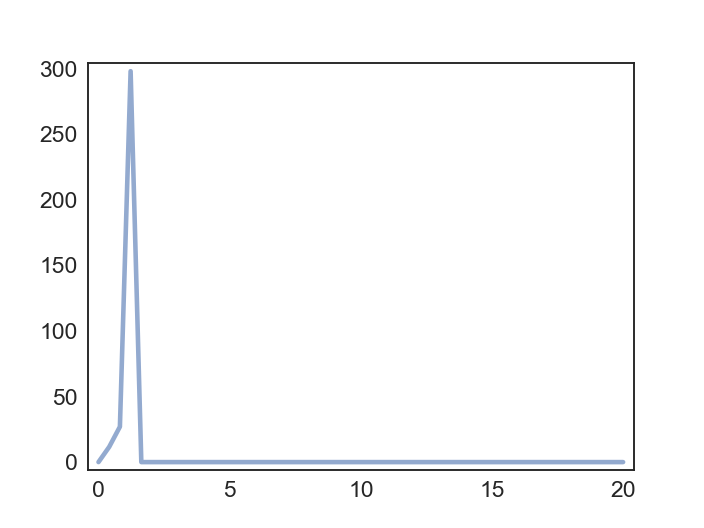

In [56]:
# Frisbee system more like... frisbee system
frisbee = make_frisbee_system(30, 20, 20)
run_odeint(frisbee, frisbee_slope_func)
print(frisbee.results.y)
plot(frisbee.results.y)

In [43]:
# Wow! The pendulum system!
system = make_pendulum_system()
run_odeint(system, pendulum_slope_func)
(system.results.y)

0.00    -0.707107
0.06    -0.723730
0.12    -0.763265
0.18    -0.806178
0.24    -0.845163
0.30    -0.890589
0.36    -0.951040
0.42    -1.012459
0.48    -1.046373
0.54    -1.040659
0.60    -1.012062
0.66    -0.982550
0.72    -0.952242
0.78    -0.905808
0.84    -0.840549
0.90    -0.776466
0.96    -0.736737
1.02    -0.725521
1.08    -0.729267
1.14    -0.736925
1.20    -0.754195
1.26    -0.795270
1.32    -0.861091
1.38    -0.930554
1.44    -0.978920
1.50    -1.002874
1.56    -1.018726
1.62    -1.034299
1.68    -1.033614
1.74    -0.997648
           ...   
28.26   -1.025399
28.32   -1.018476
28.38   -1.007307
28.44   -0.973756
28.50   -0.911350
28.56   -0.839582
28.62   -0.784851
28.68   -0.754869
28.74   -0.738028
28.80   -0.724343
28.86   -0.720624
28.92   -0.742776
28.98   -0.794849
29.04   -0.859598
29.10   -0.913800
29.16   -0.951801
29.22   -0.986811
29.28   -1.025799
29.34   -1.051700
29.40   -1.040646
29.46   -0.992656
29.52   -0.933274
29.58   -0.884219
29.64   -0.843309
29.70   -0

In [26]:
# Now, let's think about combining models together... It'll be great!!!!!!!!!!

def combine_models(velocity, angle, duration):
    """
    Combines frisbee and pendulum models to describe a system where a frisbee flies through the air
    from (0, 0)
    """    
    frisbee = make_frisbee_system(velocity, angle, duration)
    run_odeint(frisbee, frisbee_slope_func)
    time_series = linrange(0, duration)   
    
    fx = interpolate(frisbee.results.x)
    i_fx = fx(time_series)
    fy = interpolate(frisbee.results.y)
    i_fy = fy(time_series)
    
    pendulum = make_pendulum_system()
    run_odeint(pendulum, pendulum_slope_func)
    px = interpolate(pendulum.results.x)
    i_px = px(time_series)
    py = interpolate(pendulum.results.y)
    i_py = py(time_series)  
    
    x_combined = np.add(i_fx, i_px)
    plot(time_series, x_combined)
    y_combined = np.add(i_fy, i_py)
    plot(time_series, y_combined) 
   # plot(x_combined, y_combined)
    
    
    
combine_models(30, 10, 10)
          
    